In [ ]:
!ls

sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tqdm

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import utils

import os
import nibabel as nib
import copy

import matplotlib.pyplot as plt
%matplotlib inline

import random
import skimage.transform as skTrans

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Transformations

In [ ]:
class ScaleToFixed(object):

    def __init__(self, new_shape, interpolation=1, channels=4):
        self.shape= new_shape
        self.interpolation = interpolation
        self.channels = channels

    def __call__(self, image):
        # print('first shape', image.shape)
        if image is not None: # (some patients don't have segmentations)
            if self.channels == 1:
                short_shape = (self.shape[1], self.shape[2], self.shape[3])
                image = skTrans.resize(image, short_shape, order=self.interpolation, preserve_range=True)  #
                image = image.reshape(self.shape)
            else:
                image = skTrans.resize(image, self.shape, order=self.interpolation, preserve_range=True)  #

        # print('second shape', image.shape)
        # print()
        return image

class RandomFlip(object):
    """Randomly flips (horizontally as well as vertically) the given PIL.Image with a probability of 0.5
    """
    def __init__(self, prob_flip=0.5):
        self.prob_flip= prob_flip
    def __call__(self, image):

        if random.random() < self.prob_flip:
            flip_type = np.random.randint(0, 3) # flip across any 3D axis
            image = np.flip(image, flip_type)
        return image

class ZeroChannel(object):
    """Randomly sets channel to zero the given PIL.Image with a probability of 0.25
    """
    def __init__(self, prob_zero=0.25, channels=4):
        self.prob_zero= prob_zero
        self.channels = channels
    def __call__(self, image):

        if np.random.random() < self.prob_zero:
            channel_to_zero = np.random.randint(0, self.channels) # flip across any 3D axis
            zeros = np.zeros((image.shape[1], image.shape[2], image.shape[3]))
            image[channel_to_zero, :, :, :] = zeros
        return image

class ZeroSprinkle(object):
    def __init__(self, prob_zero=0.25, prob_true=0.5, channels=4):
        self.prob_zero=prob_zero
        self.prob_true=prob_true
        self.channels=channels
    def __call__(self, image):

        if self.prob_true:
            mask = np.random.rand(image.shape[0], image.shape[1], image.shape[2], image.shape[3])
            mask[mask < self.prob_zero] = 0
            mask[mask > 0] = 1
            image = image*mask

        return image


class MinMaxNormalize(object):
    """Min-Max normalization
    """
    def __call__(self, image):
        def norm(im):
            im = im.astype(np.float32)
            min_v = np.min(im)
            max_v = np.max(im)
            im = (im - min_v)/(max_v - min_v)
            return im
        image = norm(image)
        return image

class ToTensor(object):
    def __init__(self, scale=1):
        self.scale = scale

    def __call__(self, image):
        if image is not None:
            image = image.astype(np.float32)
            image = image.reshape((image.shape[0], int(image.shape[1]/self.scale), int(image.shape[2]/self.scale), int(image.shape[3]/self.scale)))
            image_tensor = torch.from_numpy(image)
            return image_tensor
        else:
            return image


class Compose(object):
    """
    Composes several transforms together.
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for i, t in enumerate(self.transforms):
            image = t(image)
        return image

# Data

In [ ]:
image_dir = 'drive/MyDrive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/'

naming = pd.read_csv(f'drive/MyDrive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/name_mapping.csv')
data_df = pd.DataFrame(naming['BraTS_2020_subject_ID'])

In [ ]:
channels = 4
resize_shape = (160, 160, 144)

In [ ]:
n_p = 50 # n_patients_to_train_with

train_df = data_df[:n_p]
print(train_df.shape)
valid_df = data_df[n_p:n_p*2]

(50, 1)


In [ ]:

# basic data augmentation
prob_voxel_zero = 0 # 0.1
prob_channel_zero = 0 # 0.5
prob_true = 0 # 0.8
randomflip = RandomFlip()

# MRI transformations
train_transformations = Compose([
    MinMaxNormalize(),
    ScaleToFixed((channels, resize_shape[0],resize_shape[1],resize_shape[2]),
                          interpolation=1,
                          channels=channels),
    ZeroSprinkle(prob_zero=prob_voxel_zero, prob_true=prob_true),
    ZeroChannel(prob_zero=prob_channel_zero),
    randomflip,
    ToTensor()
])


In [ ]:
# GT segmentation mask transformations

seg_transformations = Compose([
            ScaleToFixed((1, resize_shape[0],resize_shape[1],resize_shape[2]),
                                      interpolation=0,
                                      channels=1),
            randomflip,
            ToTensor(),
        ])

# Dataloader

In [ ]:
def get_bb_3D(img, pad=0):
    '''
    This function returns a tumor 3D bounding box using a segmentation mask
    '''
    xs = np.nonzero(np.sum(np.sum(img, axis=1), axis=1))
    ys = np.nonzero(np.sum(np.sum(img, axis=0), axis=1))
    zs = np.nonzero(np.sum(np.sum(img, axis=0), axis=0))
    xmin, xmax = np.min(xs), np.max(xs)
    ymin, ymax = np.min(ys), np.max(ys)
    zmin, zmax = np.min(zs), np.max(zs)
    bbox = (xmin-pad, ymin-pad, zmin-pad, xmax+pad, ymax+pad, zmax+pad)
    return bbox

def min_max(img):
    '''
    Min-max normalization
    '''
    return (img - img.min()) / (img.max() - img.min())

def read_mri(mr_path_dict, pad=0):

    image_shape = nib.load(mr_path_dict['flair']).get_fdata().shape
    bb_seg = get_bb_3D(nib.load(mr_path_dict['flair']).get_fdata())
    (xmin, ymin, zmin, xmax, ymax, zmax) = bb_seg

    xmin = np.max([0, xmin-pad])
    ymin = np.max([0, ymin-pad])
    zmin = np.max([0, zmin-pad])

    xmax = np.min([image_shape[0]-1, xmax+pad])
    ymax = np.min([image_shape[1]-1, ymax+pad])
    zmax = np.min([image_shape[2]-1, zmax+pad])


    img_dict = {}
    for key in ['flair', 't1', 't1ce', 't2', 'seg']:
        img = nib.load(mr_path_dict[key])
        img_data = img.get_fdata()
        img_dict[key] = img_data[xmin:xmax, ymin:ymax, zmin:zmax]

    stacked_img = np.stack([min_max(img_dict['flair']), min_max(img_dict['t1']),min_max(img_dict['t1ce']),min_max(img_dict['t2'])], axis=0)
    return stacked_img, img_dict['seg']


In [ ]:
from torch.utils.data import Dataset
class GeneralDataset(Dataset):

    def __init__(self,
                metadata_df,
                root_dir,
                transform=None,
                seg_transform=None, ###
                dataformat=None, # indicates what shape (or content) should be returned (2D or 3D, etc.)
                returndims=None, # what size/shape 3D volumes should be returned as.
                visualize=False,
                modality=None,
                pad=2,
                device='cpu'):
        """
        Args:
            metadata_df (string): Path to the csv file w/ patient IDs
            root_dir (string): Directory for MR images
            transform (callable, optional)
        """
        self.device=device
        self.metadata_df = metadata_df
        self.root_dir = root_dir
        self.transform = transform
        self.seg_transform = seg_transform
        self.returndims=returndims
        self.modality = modality
        self.pad = pad


    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        BraTS20ID = self.metadata_df.iloc[idx].BraTS_2020_subject_ID

        # make dictonary of paths to MRI volumnes (modalities) and segmenation masks
        mr_path_dict = {}
        sequence_type = ['seg', 't1', 't1ce', 'flair', 't2']
        for seq in sequence_type:
            mr_path_dict[seq] = os.path.join(self.root_dir, BraTS20ID, BraTS20ID + '_'+seq+'.nii.gz')

        image, seg_image = read_mri(mr_path_dict=mr_path_dict, pad=self.pad)

        if seg_image is not None: # ??
            seg_image[seg_image == 4] = 3 # 3, 160, 160, 160

        if self.transform:
            image = self.transform(image)
        if self.seg_transform:
            seg_image = self.seg_transform(seg_image)
        else:
            print('no transform')

        return (image, seg_image), BraTS20ID

In [ ]:
transformed_dataset_train = GeneralDataset(metadata_df=train_df,
                                           root_dir=image_dir,
                                           transform=train_transformations,
                                           seg_transform=seg_transformations,
                                           returndims=resize_shape)

transformed_dataset_valid = GeneralDataset(metadata_df=valid_df,
                                           root_dir=image_dir,
                                           transform=train_transformations,
                                           seg_transform=seg_transformations,
                                           returndims=resize_shape)

In [ ]:
train_batch_size = 1
dataloader_train = DataLoader(transformed_dataset_train, batch_size=train_batch_size, shuffle=True, num_workers=0)
dataloader_valid = DataLoader(transformed_dataset_valid, batch_size=train_batch_size, shuffle=True, num_workers=0)

# Visual from Dataloader

BraTS20_Training_041 
image size: torch.Size([1, 4, 160, 160, 144])


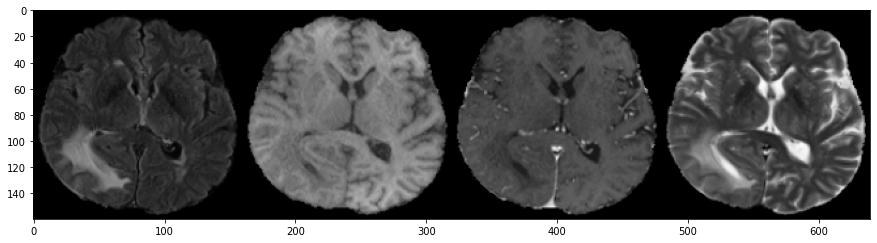

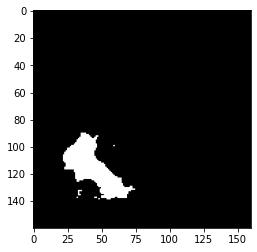

In [ ]:
# visualize training (or validation) data
for i, data in enumerate(dataloader_train):
    # data batch
    (image, seg_image), bratsID = data
    # print scan ID
    print(bratsID[0], '\nimage size:', image.shape)

    # format MRI images (slices of volumetric input)
    img = image[0,:, :, :, int(image.shape[-1]/2)].squeeze()
    img = utils.make_grid(img)
    img = img.detach().cpu().numpy()

    # plot images
    plt.figure(figsize=(15, 8))
    img_list = [img[i].T for i in range(channels)] # 1 image per channel
    plt.imshow(np.hstack(img_list), cmap='Greys_r')
    plt.show()

    ## plot segmentation mask ##
    seg_img = seg_image[0, :, :, :, int(seg_image.shape[-1]/2)].squeeze()
    seg_img = utils.make_grid(seg_img).detach().cpu().numpy()

    plt.figure(figsize=(4, 4))
    plt.imshow(np.hstack([seg_img[0].T]), cmap='Greys_r')
    plt.show()

    break

In [ ]:
# Set random seed for reproduciablity
torch.manual_seed(577)
random.seed(577)

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                        in_channels=4, out_channels=4, init_features=8,
                        pretrained=False)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip


In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
  model = model.cuda()

In [ ]:
use_cuda

True

In [ ]:
1, 4, x, y, z
image[0, :, :, :, 0-z]
for loop
1, z, 4, x, y
z, 4, x, y

c, h, w -> n, c, h, w
c, h, w, d -> n, c, h, w, d -> if n=1 -> n, d, c, h, w -> nd, c, h, w

n, h, w, d

8 batches=patients, 4 channels, 144, 144, 144 -> 5Dim, comes out of our dataloader(batch_size=8)

(n_patients * 144), 1 channel, 144, 144 -> 4 Dim goes into the dataloader(beibin)
8 batches, 1 channel, 144, 144 -> 4 Dim comes out the dataloader(beibin)


SyntaxError: ignored

In [ ]:

num_epochs = 5

for epoch in range(num_epochs):
  losses = []
  if dataloader_train is None or optimizer is None:
    break  # NotImplementedError
  for data in tqdm.tqdm(dataloader_train):
    (image, seg_image), bratsID = data
    print(image.shape)
    # p_image = image.permute(0, 4, 1, 2, 3).squeeze()
    # p_seg_image = seg_image.permute(0, 4, 1, 2, 3).squeeze()
    p_image = torch.squeeze(torch.permute(image, (0, 4, 1, 2, 3))) #
    p_seg_image = torch.squeeze(torch.permute(seg_image, (0, 4, 1, 2, 3))) #, 0)
    if use_cuda:
      p_image, p_seg_image = p_image.cuda(), p_seg_image.cuda()
    pred = model(p_image.float())
    # print(pred.size(), p_seg_image.size())# [160, 1, 160, 160]
    loss = criterion(pred, p_seg_image.long()) # .long())
    # print(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss.item())

  print("Epoch:", epoch, "Mean Loss:", np.mean(losses))

# K-fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset
from torch import nn

In [ ]:
def kFoldRun(k_folds, train_data, validation_data, num_epochs, network):
  torch.manual_seed(42)

  loss_function = nn.CrossEntropyLoss()

  dataset = ConcatDataset([train_data, validation_data])

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=k_folds, shuffle=True)

  # Start print
  print('--------------------------------')

  # K-fold Cross Validation model evaluation
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_batch_size = 1
    dataloader_train = DataLoader(dataset, batch_size=train_batch_size,sampler=train_subsampler,num_workers=0)
    dataloader_valid = DataLoader(dataset, batch_size=train_batch_size,sampler=test_subsampler, num_workers=0)

    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss value
      current_loss = 0.0

      # Iterate over the DataLoader for training data
      if dataloader_train is None or optimizer is None:
        print('None')
        break  # NotImplementedError
      for i, data in enumerate(tqdm.tqdm(dataloader_train)):
        # Get inputs
        (image, seg_image), ID = data
        inputs = torch.squeeze(torch.permute(image, (0, 4, 1, 2, 3))) #
        label = torch.squeeze(torch.permute(seg_image, (0, 4, 1, 2, 3))) #, 0)
        inputs, label = inputs.cuda(), label.cuda() # add this line
        # Zero the gradients
        optimizer.zero_grad()
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, label.long())
        print('Loss:', loss.item())
        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0
    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), 'drive/MyDrive/Colab Notebooks/')

    # Print about testing
    print('Starting testing')
    # Evaluationfor this fold
    correct, total = 0, 0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(dataloader_valid, 0):

        # Get inputs
        inputs, targets = data
        inputs = torch.squeeze(torch.permute(image, (0, 4, 1, 2, 3))) #
        label = torch.squeeze(torch.permute(seg_image, (0, 4, 1, 2, 3))) #, 0)
        inputs, label = inputs.cuda(), label.cuda() # add this line

        # Generate outputs
        outputs = network(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)

  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
  print('--------------------------------')
  sum = 0.0
  for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
  print(f'Average: {sum/len(results.items())} %')

  return results

In [ ]:
kFoldRun(2, transformed_dataset_train, transformed_dataset_valid, 5, model)

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1


  0%|          | 0/50 [00:00<?, ?it/s]

Loss: 1.4135862588882446


  2%|▏         | 1/50 [00:07<06:20,  7.77s/it]

Loss: 1.4052852392196655


  4%|▍         | 2/50 [00:14<05:44,  7.18s/it]

Loss: 1.4009777307510376


  6%|▌         | 3/50 [00:21<05:33,  7.09s/it]

Loss: 1.4015039205551147


  8%|▊         | 4/50 [00:29<05:43,  7.46s/it]

Loss: 1.407473087310791


 10%|█         | 5/50 [00:36<05:34,  7.43s/it]

Loss: 1.3996520042419434


 12%|█▏        | 6/50 [00:43<05:17,  7.21s/it]

Loss: 1.4012222290039062


 14%|█▍        | 7/50 [00:51<05:12,  7.28s/it]

Loss: 1.4050887823104858


 16%|█▌        | 8/50 [00:58<05:04,  7.26s/it]

Loss: 1.4014904499053955


 18%|█▊        | 9/50 [01:05<04:57,  7.27s/it]

Loss: 1.3993794918060303


 20%|██        | 10/50 [01:12<04:42,  7.07s/it]

Loss: 1.3995840549468994


 22%|██▏       | 11/50 [01:19<04:35,  7.07s/it]

Loss: 1.4027799367904663


 24%|██▍       | 12/50 [01:26<04:27,  7.05s/it]

Loss: 1.394897699356079


 26%|██▌       | 13/50 [01:33<04:22,  7.09s/it]

Loss: 1.3985861539840698


 28%|██▊       | 14/50 [01:40<04:11,  6.98s/it]

Loss: 1.396349310874939


 30%|███       | 15/50 [01:49<04:15,  7.31s/it]


KeyboardInterrupt: ignored

In [ ]:

num_epochs = 6

for epoch in range(num_epochs):
  losses = []
  if dataloader_train is None or optimizer is None:
    break  # NotImplementedError
  for data in tqdm.tqdm(dataloader_train):
    (image, seg_image), bratsID = data
    # p_image = image.permute(0, 4, 1, 2, 3).squeeze()
    # p_seg_image = seg_image.permute(0, 4, 1, 2, 3).squeeze()
    p_image = torch.squeeze(torch.permute(image, (0, 4, 1, 2, 3)))[:, 0, :, :].unsqueeze(1) #
    p_seg_image = torch.squeeze(torch.permute(seg_image, (0, 4, 1, 2, 3))) #, 0)

    # print(p_seg_image.shape)
    # print(f"unique input seg: {np.unique(p_seg_image)}")
    # p_seg_image = torch.permute(torch.tensor(to_categorical(p_seg_image)), (0, 3, 1, 2))# [:, 1:, :, :]
    # print(f"unique input seg long: {np.unique(p_seg_image.long())}, with shape {p_seg_image.shape}")

    if use_cuda:
      p_image, p_seg_image = p_image.cuda(), p_seg_image.cuda()
    pred = model(p_image.float())

    # print(pred.size(), p_seg_image.size())# [160, 1, 160, 160]
    # print(f"unique input pred: {np.unique(pred.detach().numpy())}")

    loss = criterion(pred, p_seg_image.long())
    print(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss.item())

  print("Epoch:", epoch, "Mean Loss:", np.mean(losses))

In [ ]:
torch.save(model, 'drive/MyDrive/Colab Notebooks/flairmriseg.pt')


In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'drive/MyDrive/Colab Notebooks/resumable_flair_1_mriseg.pt')

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                        in_channels=1, out_channels=4, init_features=8,
                        pretrained=False)

use_cuda = torch.cuda.is_available()
if use_cuda:
  model = model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

PATH = 'drive/MyDrive/Colab Notebooks/resumable_flairmriseg.pt'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#model.eval()
# - or -
model.train()

In [ ]:

num_epochs = 10

for epoch in range(num_epochs):
  losses = []
  if dataloader_train is None or optimizer is None:
    break  # NotImplementedError
  for data in tqdm.tqdm(dataloader_train):
    (image, seg_image), bratsID = data

    p_image = torch.squeeze(torch.permute(image, (0, 4, 1, 2, 3)))[:, 0, :, :].unsqueeze(1) #
    p_seg_image = torch.squeeze(torch.permute(seg_image, (0, 4, 1, 2, 3))) #, 0)

    if use_cuda:
      p_image, p_seg_image = p_image.cuda(), p_seg_image.cuda()
    pred = model(p_image.float())
    loss = criterion(pred, p_seg_image.long())

    print(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())

  print("Epoch:", epoch, "Mean Loss:", np.mean(losses))

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

batch_size = 144
summary(model, input_size=(batch_size, 1, 160, 160))